In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ctgan.synthesizers.ctgan import CTGAN
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import evaluate_quality

import warnings
warnings.filterwarnings('ignore')

In [53]:
current_directory = os.path.abspath(os.getcwd())
parent_directory = os.path.join(current_directory, '..')
grandparent_directory = os.path.join(parent_directory, '..')
data_directory = os.path.join(grandparent_directory, 'data')
csv_path = os.path.join(data_directory, 'healthcare_dataset.csv')

df = pd.read_csv(csv_path)
df.head().T

,0,1,2,3,4
Name,Tiffany Ramirez,Ruben Burns,Chad Byrd,Antonio Frederick,Mrs. Brandy Flowers
Age,81,35,61,49,51
Gender,Female,Male,Male,Male,Male
Blood Type,O-,O+,B-,B-,O-
Medical Condition,Diabetes,Asthma,Obesity,Asthma,Arthritis
Date of Admission,2022-11-17,2023-06-01,2019-01-09,2020-05-02,2021-07-09
Doctor,Patrick Parker,Diane Jackson,Paul Baker,Brian Chandler,Dustin Griffin
Hospital,Wallace-Hamilton,"Burke, Griffin and Cooper",Walton LLC,Garcia Ltd,"Jones, Brown and Murray"
Insurance Provider,Medicare,UnitedHealthcare,Medicare,Medicare,UnitedHealthcare
Billing Amount,37490.983364,47304.064845,36874.896997,23303.322092,18086.344184


In [54]:
# creating synthesizing and augmentation copy
df_synthetic = df.copy()
df_augmented = df.copy()

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                10000 non-null  object 
 1   Age                 10000 non-null  int64  
 2   Gender              10000 non-null  object 
 3   Blood Type          10000 non-null  object 
 4   Medical Condition   10000 non-null  object 
 5   Date of Admission   10000 non-null  object 
 6   Doctor              10000 non-null  object 
 7   Hospital            10000 non-null  object 
 8   Insurance Provider  10000 non-null  object 
 9   Billing Amount      10000 non-null  float64
 10  Room Number         10000 non-null  int64  
 11  Admission Type      10000 non-null  object 
 12  Discharge Date      10000 non-null  object 
 13  Medication          10000 non-null  object 
 14  Test Results        10000 non-null  object 
dtypes: float64(1), int64(2), object(12)
memory usage: 1.1+

In [56]:
df.columns

Index(['Name', 'Age', 'Gender', 'Blood Type', 'Medical Condition',
       'Date of Admission', 'Doctor', 'Hospital', 'Insurance Provider',
       'Billing Amount', 'Room Number', 'Admission Type', 'Discharge Date',
       'Medication', 'Test Results'],
      dtype='object')

In [57]:
df.nunique()

Name                   9378
Age                      68
Gender                    2
Blood Type                8
Medical Condition         6
Date of Admission      1815
Doctor                 9416
Hospital               8639
Insurance Provider        5
Billing Amount        10000
Room Number             400
Admission Type            3
Discharge Date         1834
Medication                5
Test Results              3
dtype: int64

#### Synthesizing

In [58]:
not_imp_cols = ['Name', 'Date of Admission', 'Doctor', 'Hospital', 'Insurance Provider', 'Billing Amount', 'Room Number', 'Admission Type', 'Discharge Date']
discrete_cols = ['Age', 'Gender', 'Blood Type', 'Medical Condition', 'Medication', 'Test Results']

In [59]:
df_synthetic = df_synthetic.drop(not_imp_cols, axis=1)
df_synthetic.head().T

,0,1,2,3,4
Age,81,35,61,49,51
Gender,Female,Male,Male,Male,Male
Blood Type,O-,O+,B-,B-,O-
Medical Condition,Diabetes,Asthma,Obesity,Asthma,Arthritis
Medication,Aspirin,Lipitor,Lipitor,Penicillin,Paracetamol
Test Results,Inconclusive,Normal,Normal,Abnormal,Normal


In [60]:
ctgan = CTGAN(epochs=10)
ctgan.fit(df_synthetic, discrete_cols)

In [61]:
synthesized_data = ctgan.sample(1000)
synthesized_data.head().T

,0,1,2,3,4
Age,40,41,61,80,81
Gender,Female,Female,Male,Female,Female
Blood Type,A+,AB-,A-,O+,B-
Medical Condition,Diabetes,Cancer,Cancer,Asthma,Obesity
Medication,Lipitor,Penicillin,Ibuprofen,Ibuprofen,Aspirin
Test Results,Normal,Inconclusive,Abnormal,Inconclusive,Normal


##### Augmented

In [62]:
df_augmented = df_augmented.drop(not_imp_cols, axis=1)
df_augmented.head().T

,0,1,2,3,4
Age,81,35,61,49,51
Gender,Female,Male,Male,Male,Male
Blood Type,O-,O+,B-,B-,O-
Medical Condition,Diabetes,Asthma,Obesity,Asthma,Arthritis
Medication,Aspirin,Lipitor,Lipitor,Penicillin,Paracetamol
Test Results,Inconclusive,Normal,Normal,Abnormal,Normal


In [63]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df_augmented)

In [64]:
model = CTGANSynthesizer(metadata=metadata)
model.fit(df_augmented)

In [65]:
augmented_data = model.sample(1000)
augmented_data.head().T

,0,1,2,3,4
Age,26,55,18,24,67
Gender,Male,Male,Male,Female,Male
Blood Type,B+,O+,A+,O-,A-
Medical Condition,Diabetes,Asthma,Arthritis,Obesity,Asthma
Medication,Penicillin,Aspirin,Aspirin,Lipitor,Paracetamol
Test Results,Abnormal,Abnormal,Inconclusive,Normal,Abnormal


#### Testing Accuracy

In [66]:
df = df.drop(not_imp_cols, axis=1)

Text(0.5, 1.0, 'Synthesized Data')

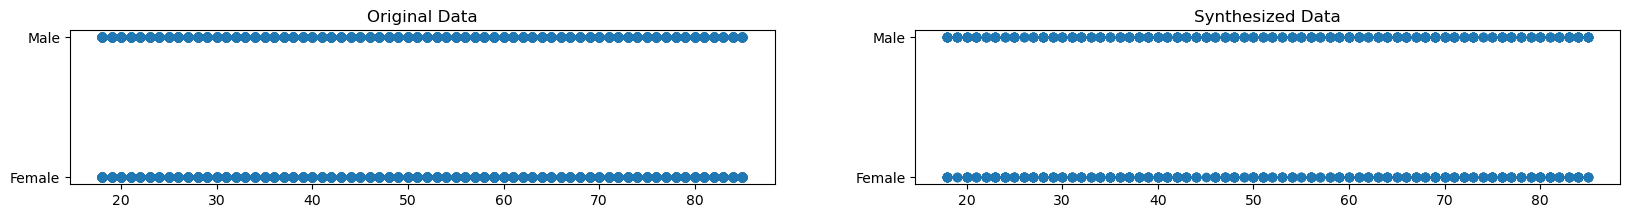

In [84]:
fig, ax = plt.subplots(1, 2, figsize=(20, 2))
ax[0].scatter(df.iloc[:, 0], df.iloc[:, 1])
ax[1].scatter(synthesized_data.iloc[:, 0], synthesized_data.iloc[:, 1])
ax[0].set_title("Original Data")
ax[1].set_title("Synthesized Data")

Text(0.5, 1.0, 'Augmented Data')

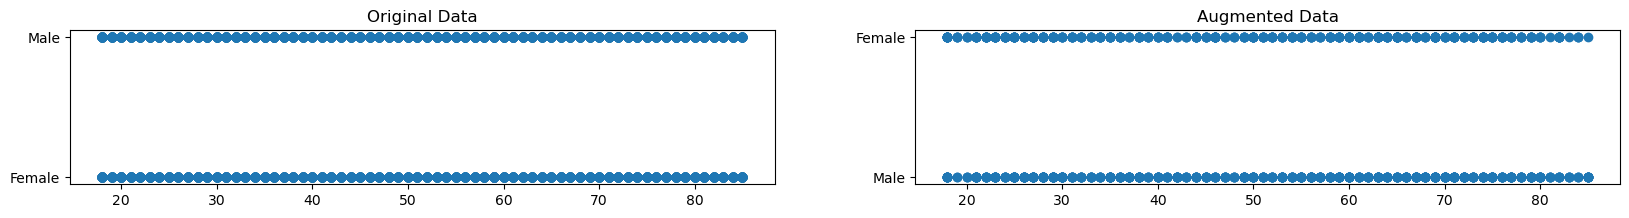

In [83]:
fig, ax = plt.subplots(1, 2, figsize=(20, 2))
ax[0].scatter(df.iloc[:, 0], df.iloc[:, 1])
ax[1].scatter(augmented_data.iloc[:, 0], augmented_data.iloc[:, 1])
ax[0].set_title("Original Data")
ax[1].set_title("Augmented Data")

In [69]:
# converting data to sns plotable
df_plotable = df.copy()
synthetic_plotable = synthesized_data.copy()
augmented_plotable = augmented_data.copy()

In [70]:
gender_map = {'Male': 0, 'Female': 1}

df_plotable.replace(gender_map, inplace=True)
synthetic_plotable.replace(gender_map, inplace=True)
augmented_plotable.replace(gender_map, inplace=True)

blood_map = {}
for i in range(len(df_plotable['Blood Type'].unique())):
    blood_map[df_plotable['Blood Type'].unique()[i]] = i

med_con_map = {}
for i in range(len(df_plotable['Medical Condition'].unique())):
    blood_map[df_plotable['Medical Condition'].unique()[i]] = i

medication = {}
for i in range(len(df_plotable['Medication'].unique())):
    blood_map[df_plotable['Medication'].unique()[i]] = i

test_result_maps = {}
for i in range(len(df_plotable['Test Results'].unique())):
    blood_map[df_plotable['Test Results'].unique()[i]] = i

In [71]:
df_plotable.replace(blood_map, inplace=True)
synthetic_plotable.replace(blood_map, inplace=True)
augmented_plotable.replace(blood_map, inplace=True)

df_plotable.replace(med_con_map, inplace=True)
synthetic_plotable.replace(med_con_map, inplace=True)
augmented_plotable.replace(med_con_map, inplace=True)

df_plotable.replace(medication, inplace=True)
synthetic_plotable.replace(medication, inplace=True)
augmented_plotable.replace(medication, inplace=True)

df_plotable.replace(test_result_maps, inplace=True)
synthetic_plotable.replace(blood_map, inplace=True)
augmented_plotable.replace(blood_map, inplace=True)

df_plotable.replace(blood_map, inplace=True)
synthetic_plotable.replace(blood_map, inplace=True)
augmented_plotable.replace(blood_map, inplace=True)

Text(0.5, 1.0, 'Synthesized Data')

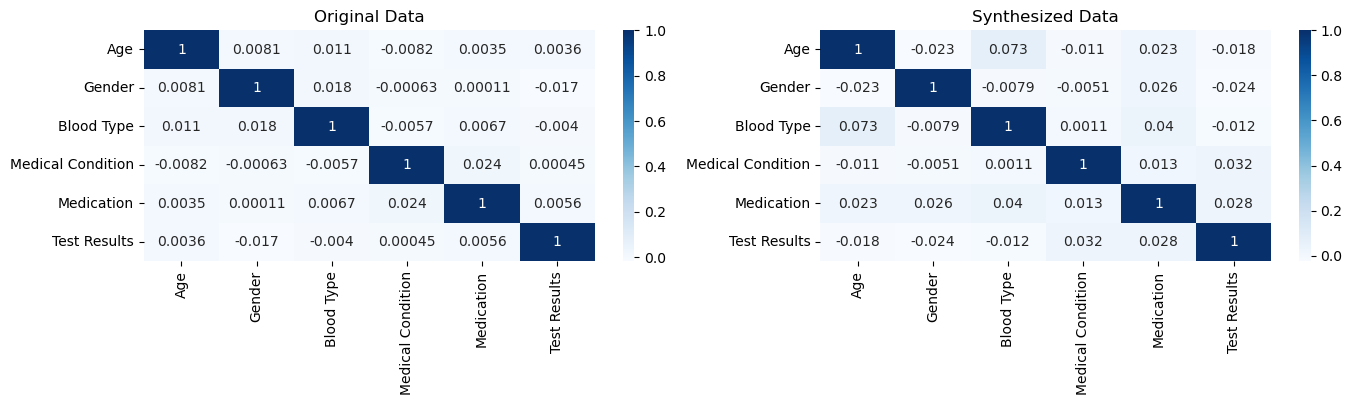

In [81]:
fig, ax = plt.subplots(1, 2, figsize=(16, 3))
sns.heatmap(df_plotable.corr(), annot=True, ax=ax[0], cmap="Blues")
sns.heatmap(synthetic_plotable.corr(), annot=True, ax=ax[1], cmap="Blues")
ax[0].set_title("Original Data")
ax[1].set_title("Synthesized Data")

Text(0.5, 1.0, 'Synthesized Data')

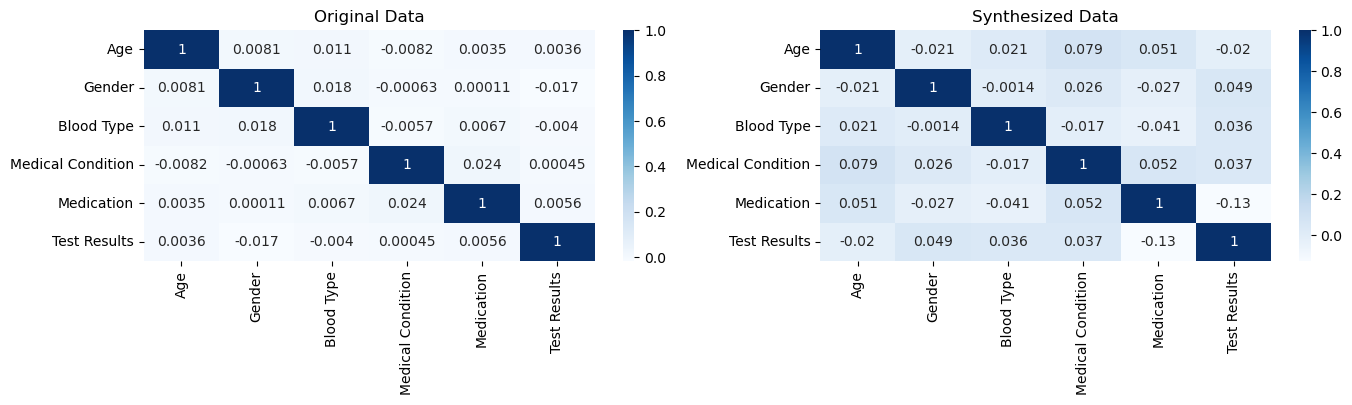

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(16, 3))
sns.heatmap(df_plotable.corr(), annot=True, ax=ax[0], cmap="Blues")
sns.heatmap(augmented_plotable.corr(), annot=True, ax=ax[1], cmap="Blues")
ax[0].set_title("Original Data")
ax[1].set_title("Synthesized Data")

In [73]:
quality_report = evaluate_quality(
    df_plotable,
    synthetic_plotable,
    metadata)

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 15/15 [00:00<00:00, 46.21it/s]

Overall Score: 95.37%

Properties:
- Column Shapes: 97.47%
- Column Pair Trends: 93.28%


In [74]:
quality_report = evaluate_quality(
    df_plotable,
    augmented_plotable,
    metadata)

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 15/15 [00:00<00:00, 56.58it/s]

Overall Score: 84.32%

Properties:
- Column Shapes: 87.78%
- Column Pair Trends: 80.86%
